In [1]:
#Importing packages
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy import stats

In [2]:
#Santander Product Recommendation Dataset
santander_data_original = pd.read_csv("Data/Raw/santander_train_ver2_eng_names.csv")

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing

In [3]:
#Extracting the last month data and dropping the date column
santander_data = santander_data_original[santander_data_original['date'] == '2016-05-28']
santander_data = santander_data.drop(['date'], axis=1)

In [4]:
#Checking the number of rows and column in dataset
santander_data.shape

(931453, 47)

In [5]:
#View the column names
santander_data.columns

Index(['customer_code', 'employee_index', 'country_of_residence', 'sex', 'age',
       'date_of_first_contract', 'new_customer_index', 'seniority',
       'customer_type', 'last_date_as_primary', 'customer_typ_at_begin',
       'customer_relation_at_begin', 'residency_index', 'foreign_index',
       'spouse_index', 'channel_used', 'deceased_index', 'address_type',
       'province_code', 'province_name', 'activity_index', 'gross_income',
       'segmentation', 'ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_payroll_account',
       'ind_junior_account', 'ind_mas_particular_account',
       'ind_particular_account', 'ind_particular_plus_account',
       'ind_short_term_deposit', 'ind_medium_term_deposit',
       'ind_long_term_deposit', 'ind_eaccount', 'ind_funds', 'ind_mortgage',
       'ind_pensions', 'ind_loans', 'ind_taxes', 'ind_credit_cards',
       'ind_securities', 'ind_home_accounts', 'ind_payrolls', 'ind_pensions_2',
       '

In [6]:
#Check the percentage of missing rows in each column
((santander_data.isnull().sum())/len(santander_data))*100

customer_code                   0.000000
employee_index                  0.000000
country_of_residence            0.000000
sex                             0.000537
age                             0.000000
date_of_first_contract          0.000000
new_customer_index              0.000000
seniority                       0.000000
customer_type                   0.000000
last_date_as_primary           99.799238
customer_typ_at_begin           0.430510
customer_relation_at_begin      0.430510
residency_index                 0.000000
foreign_index                   0.000000
spouse_index                   99.987761
channel_used                    0.719199
deceased_index                  0.000000
address_type                    0.000000
province_code                   0.428578
province_name                   0.428578
activity_index                  0.000000
gross_income                   24.587177
segmentation                    0.754198
ind_savings_account             0.000000
ind_guarantees  

In [7]:
#Drop columns with more than 99% missing values
santander_data = santander_data.drop(['last_date_as_primary', 'spouse_index'], axis=1)

In [8]:
#Removing rows with missing value in province_name (less than 0.5%) before calculating the median gross_income of each province
santander_data = santander_data.dropna(subset=["province_name"])

#Impute missing values for gross income using median of province
santander_data["gross_income"] = santander_data.groupby("province_name").gross_income.transform(lambda x: x.fillna(x.median()))

In [9]:
#For other columns the missing values are close to 0.5%, so drop all the rows with missing value
santander_data = santander_data.dropna(axis=0)

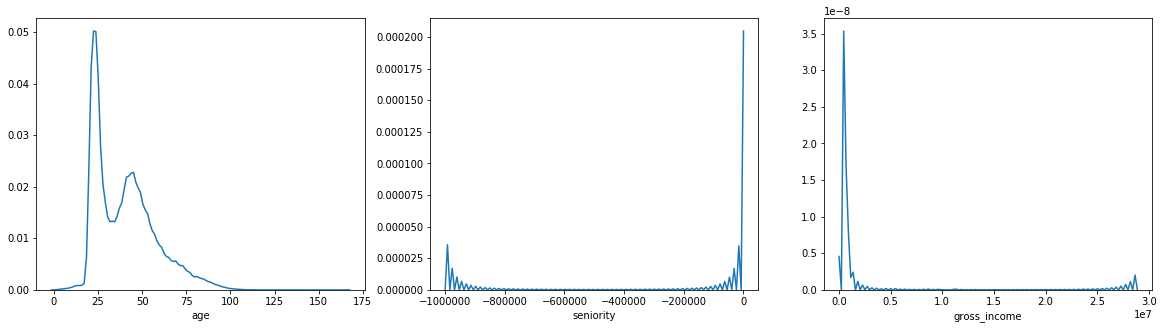

In [10]:
#Check distribution of continuous variables
f, axes = plt.subplots(1, 3,figsize=(20,5))
sns.distplot(santander_data['age'],hist=False,ax=axes[0])
sns.distplot(santander_data['seniority'],hist=False,ax=axes[1])
sns.distplot(santander_data['gross_income'],hist=False,ax=axes[2])

In [11]:
#Deleting records with seniority less than 1
santander_data = santander_data[santander_data['seniority']>0]

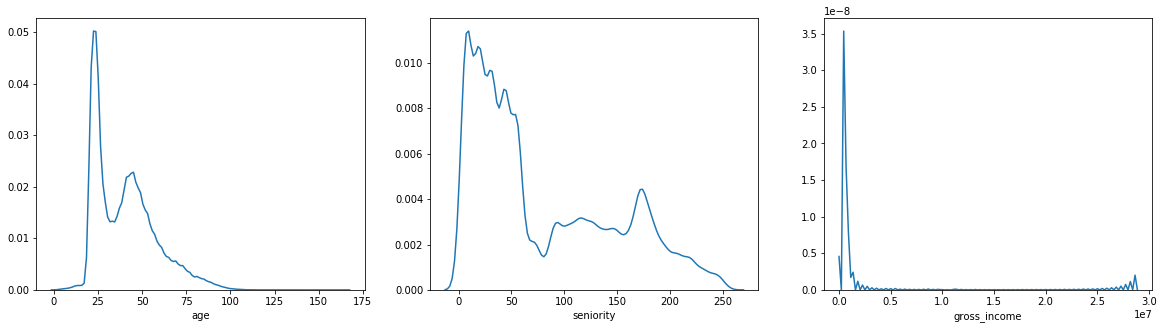

In [12]:
#Check the distribution of continuous variables after removing outliers
f, axes = plt.subplots(1, 3,figsize=(20,5))
sns.distplot(santander_data['age'],hist=False,ax=axes[0])
sns.distplot(santander_data['seniority'],hist=False,ax=axes[1])
sns.distplot(santander_data['gross_income'],hist=False,ax=axes[2])

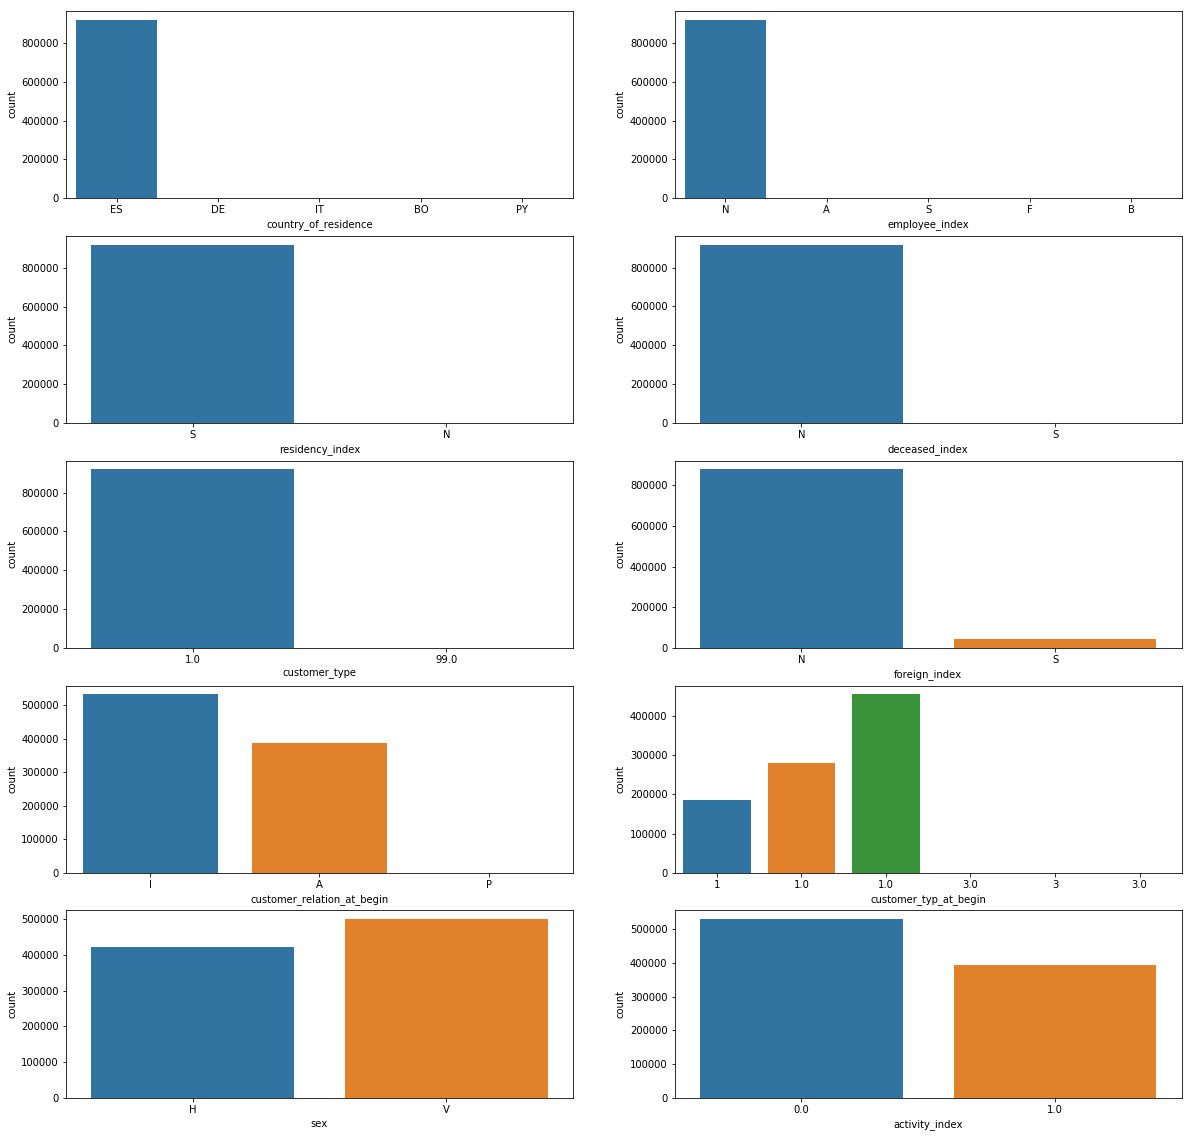

In [13]:
#Check the distribution of nominal variables
f, axes = plt.subplots(5, 2,figsize=(20,20))
sns.countplot(santander_data['country_of_residence'],ax=axes[0][0])
sns.countplot(santander_data['employee_index'],ax=axes[0][1])
sns.countplot(santander_data['residency_index'],ax=axes[1][0])
sns.countplot(santander_data['deceased_index'],ax=axes[1][1])
sns.countplot(santander_data['customer_type'],ax=axes[2][0])
sns.countplot(santander_data['foreign_index'],ax=axes[2][1])
sns.countplot(santander_data['customer_relation_at_begin'],ax=axes[3][0])
sns.countplot(santander_data['customer_typ_at_begin'],ax=axes[3][1])
sns.countplot(santander_data['sex'],ax=axes[4][0])
sns.countplot(santander_data['activity_index'],ax=axes[4][1])

In [14]:
#99.99% customers are from ES, therefore remove records of customers from other country
santander_data = santander_data[santander_data['country_of_residence'] == 'ES']

In [15]:
#99.99% customers are not empoyee of the bank, therefore remove records of customers who have been an employee at bank
santander_data = santander_data[santander_data['employee_index'] == 'N']

In [16]:
#99.99% customers are primary(1.0) at beginning of month, therefore remove records of other customers
#column has mixed data type, therefore converting all to float before dropping
santander_data['customer_typ_at_begin'] = santander_data['customer_typ_at_begin'].astype(float)
santander_data = santander_data[santander_data['customer_typ_at_begin'] == 1.0]

In [17]:
#99.99% customers have deceased index as N, therefore remove other records
santander_data = santander_data[santander_data['deceased_index'] == 'N']

In [18]:
#99.8% customer are of primary(1.0) type, therefore remove other records
santander_data = santander_data[santander_data['customer_type'] == 1.0]

In [19]:
#We dont consider the former customers for analysis, therefore keep only active or inactive customers
santander_data = santander_data[santander_data['customer_relation_at_begin'].isin(['A', 'I'])]

In [20]:
# Convert spanish notations for sex to english notations
santander_data['sex'] = santander_data['sex'].str.replace('H','F')
santander_data['sex'] = santander_data['sex'].str.replace('V','M')

In [21]:
# Convert spanish notations for segmentation to english notations
santander_data['segmentation'] = santander_data['segmentation'].str.replace('01 - TOP','VIP')
santander_data['segmentation'] = santander_data['segmentation'].str.replace('02 - PARTICULARES','INDIVIDUALS')
santander_data['segmentation'] = santander_data['segmentation'].str.replace('03 - UNIVERSITARIO','UNIVERSITY')

In [22]:
#Changing the data type of activity index from float to nominal
santander_data['activity_index'] = (santander_data['activity_index'].astype(int)).astype(object)

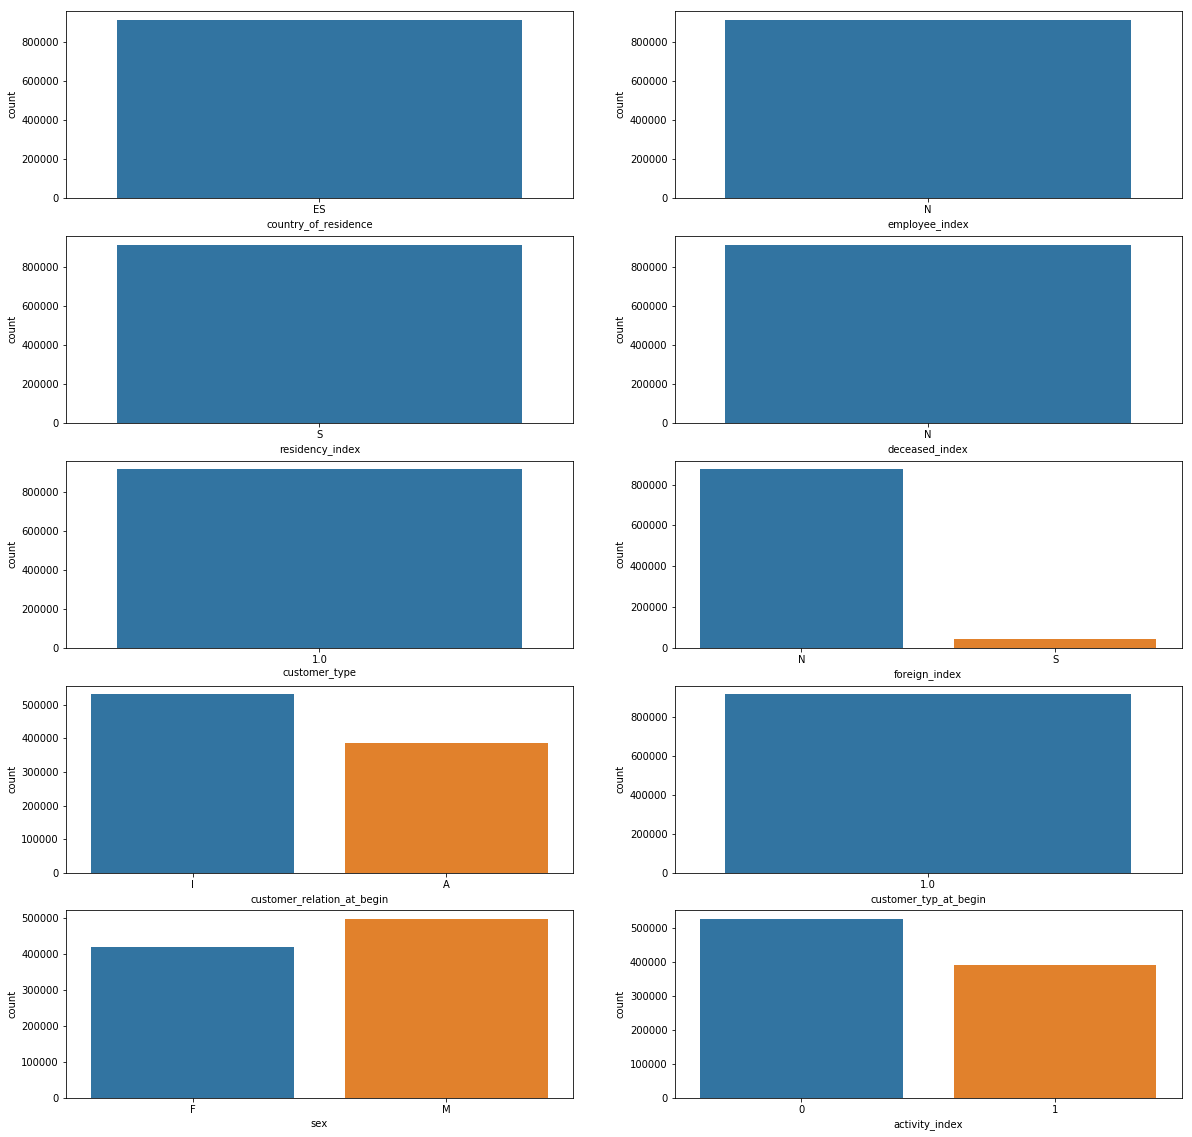

In [23]:
#Check the distribution of nominal variables after preprocessing
f, axes = plt.subplots(5, 2,figsize=(20,20))
sns.countplot(santander_data['country_of_residence'],ax=axes[0][0])
sns.countplot(santander_data['employee_index'],ax=axes[0][1])
sns.countplot(santander_data['residency_index'],ax=axes[1][0])
sns.countplot(santander_data['deceased_index'],ax=axes[1][1])
sns.countplot(santander_data['customer_type'],ax=axes[2][0])
sns.countplot(santander_data['foreign_index'],ax=axes[2][1])
sns.countplot(santander_data['customer_relation_at_begin'],ax=axes[3][0])
sns.countplot(santander_data['customer_typ_at_begin'],ax=axes[3][1])
sns.countplot(santander_data['sex'],ax=axes[4][0])
sns.countplot(santander_data['activity_index'],ax=axes[4][1])

In [24]:
#Drop the columns that has only one level of data
santander_data = santander_data.drop(['customer_type','country_of_residence', 'employee_index', 'customer_typ_at_begin', 'residency_index',
                                     'deceased_index'], axis=1)

#### Removing columns from analysis
1. Drop <i>date_of_first_contract</i> because it will correlate with seniority
2. Drop <i>address_type</i> and <i>province_code</i> because they can be inferred from the province_name
3. Drop <i>channel_used</i> because the values are masked

In [25]:
#Dropping columns from analysis
santander_data = santander_data.drop(['date_of_first_contract','address_type','province_code','channel_used'], axis=1)

In [26]:
#View the data information
santander_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916377 entries, 12715856 to 13647307
Data columns (total 35 columns):
customer_code                  916377 non-null int64
sex                            916377 non-null object
age                            916377 non-null float64
new_customer_index             916377 non-null float64
seniority                      916377 non-null float64
customer_relation_at_begin     916377 non-null object
foreign_index                  916377 non-null object
province_name                  916377 non-null object
activity_index                 916377 non-null object
gross_income                   916377 non-null float64
segmentation                   916377 non-null object
ind_savings_account            916377 non-null int64
ind_guarantees                 916377 non-null int64
ind_current_account            916377 non-null int64
ind_derivada_account           916377 non-null int64
ind_payroll_account            916377 non-null int64
ind_junior_account

In [27]:
#Changing data type for non-float variables to int
float_cols = ['age', 'new_customer_index', 'seniority','ind_payrolls', 'ind_pensions_2']
for item in float_cols:
    santander_data[item] = santander_data[item].astype(int)

Text(0.5,1,'Distribution of Customers by Province Segment')

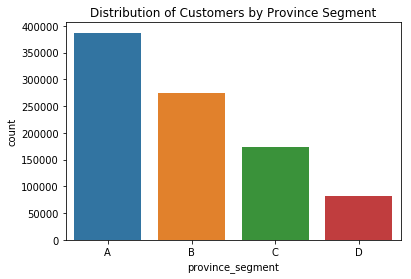

In [28]:
#Grouping provinces based on GDP
santander_data['province_segment'] = ""
province_segment_A = ['MADRID','BARCELONA','GIPUZKOA']
province_segment_B = ['VALENCIA','SEVILLA','ALICANTE','MALAGA','ZARAGOZA','CORUÑA, A','TARRAGONA','ASTURIAS','GIRONA','CADIZ',
                      'PONTEVEDRA','NAVARRA','SANTA CRUZ DE TENERIFE','ALAVA','LERIDA','Mallorca']
province_segment_C = ['MURCIA','GRANADA','CORDOBA','CASTELLON','ALMERIA','VALLADOLID','CANTABRIA','TOLEDO','JAEN','BADAJOZ',
                      'CIUDAD REAL','LEON','BURGOS','HUELVA','RIOJA, LA','BALEARS, ILLES','BIZKAIA','Gran Canaria']
province_segment_D = ['ALBACETE','LUGO','CACERES','SALAMANCA','OURENSE','HUESCA','GUADALAJARA','CUENCA','PALENCIA',
                      'ZAMORA','TERUEL','SEGOVIA','CEUTA','MELILLA','PALMAS, LAS','AVILA','SORIA','La Gomera','Menorca',
                      'Fuerteventura','Lanzarote']

santander_data.loc[santander_data['province_name'].isin(province_segment_A),'province_segment'] = 'A'
santander_data.loc[santander_data['province_name'].isin(province_segment_B),'province_segment'] = 'B'
santander_data.loc[santander_data['province_name'].isin(province_segment_C),'province_segment'] = 'C'
santander_data.loc[santander_data['province_name'].isin(province_segment_D),'province_segment'] = 'D'

sns.countplot(santander_data['province_segment'], order=santander_data['province_segment'].value_counts().sort_values(ascending = False).index)
plt.title('Distribution of Customers by Province Segment')

Text(0.5,1,'Disctribution of Customers by No. of Accounts')

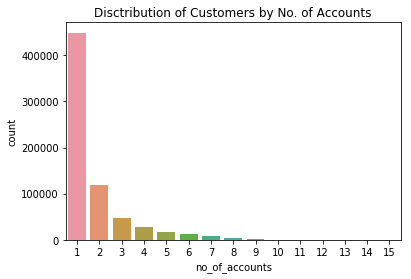

In [29]:
#Adding No. of accounts column
list_columns = list(santander_data)
list_accounts = list_columns[11:35]

santander_data['no_of_accounts'] = santander_data[list_accounts].sum(axis=1)

#Removing customers with 0 accounts
santander_data = santander_data[santander_data['no_of_accounts'] > 0]

#Distribution of total number of accounts
sns.countplot(santander_data['no_of_accounts'], order=santander_data['no_of_accounts'].value_counts().sort_values(ascending = False).index)
plt.title('Disctribution of Customers by No. of Accounts')

In [30]:
#Drop the accounts that are indicating variables
santander_data = santander_data.drop(['ind_payrolls','ind_pensions'], axis=1)

In [31]:
#Check the number of rows and columns in data after preprocessing
santander_data.shape

(689449, 35)

In [32]:
santander_data.to_csv("Data/Processed/last_month_data_processsed.csv", index=False)